# Based on Account Type + Action Type + Source Type

In [18]:
# ============================================
# Cell 1: Import Libraries
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('default')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [28]:
# ============================================
# Cell 2: Load Transaction Data
# ============================================

# Configuration: Set how many rows to load (None = load all)
N_ROWS = 300000  # Change this to your desired number, or set to None for all rows

# Load the single transaction file
data_path = "../../../data/processed/transaction_data_cleaned.csv"

if N_ROWS is not None:
    df = pd.read_csv(data_path, nrows=N_ROWS)
    print(f"⚠️  Loading only first {N_ROWS:,} rows for faster analysis")
else:
    df = pd.read_csv(data_path)
    print(f"✓ Loading all rows")

print(f"{'='*60}")
print("DATA LOADING SUMMARY")
print(f"{'='*60}")
print(f"Total transactions loaded: {len(df):,}")
print(f"Number of unique members: {df['Member ID'].nunique():,}")
print(f"Number of unique accounts: {df['Account ID'].nunique():,}")
print(f"Date range: {df['Post Date'].min()} to {df['Post Date'].max()}")
print(f"\nDataFrame shape: {df.shape}")
print(f"Column names: {list(df.columns)}")

print("\n" + "="*60)
print("FIRST 10 ROWS")
print("="*60)
print(df.head(10))

print("\n" + "="*60)
print("DATA TYPES")
print("="*60)
print(df.dtypes)

print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
print(df.isnull().sum())

⚠️  Loading only first 300,000 rows for faster analysis
DATA LOADING SUMMARY
Total transactions loaded: 300,000
Number of unique members: 1,661
Number of unique accounts: 1,662
Date range: 2024-09-01 to 2025-04-15

DataFrame shape: (300000, 15)
Column names: ['Account ID', 'Member ID', 'Account Type', 'Account Open Date', 'Member Age', 'Product ID', 'Post Date', 'Post Time', 'Amount', 'Action Type', 'Source Type', 'Transaction Description', 'Fraud Adjustment Indicator', 'Is_Fraud', 'Amount_missing']

FIRST 10 ROWS
   Account ID  Member ID        Account Type Account Open Date  Member Age  \
0  6190877696   15336793  General Membership        2007-12-15          46   
1  8892002798  878709545  General Membership        2023-05-22          28   
2  8015188961  576034980  General Membership        2021-07-28          60   
3  2272989105  210401436  General Membership        2006-04-05          54   
4  5757768331  100786009                 LLC        2022-01-11          49   
5  224813500

CATEGORICAL FEATURES ANALYSIS

Account Type:
  Unique values: 14
  Distribution:
    General Membership: 290,278 (96.76%)
    LLC: 4,419 (1.47%)
    Employee: 1,528 (0.51%)
    Sole Proprietor: 1,253 (0.42%)
    Corporation: 1,160 (0.39%)
    Revocable Trust: 672 (0.22%)
    CU Official: 253 (0.08%)
    Representative Payee: 163 (0.05%)
    Partnership: 129 (0.04%)
    Non Profit: 62 (0.02%)
    Organization/Association: 48 (0.02%)
    Estate: 24 (0.01%)
    Irrevocable Trust: 7 (0.00%)
    Custodial: 4 (0.00%)

Action Type:
  Unique values: 4
  Distribution:
    Withdrawal: 269,656 (89.89%)
    Deposit: 30,266 (10.09%)
    Transfer: 61 (0.02%)
    Unknown: 17 (0.01%)

Source Type:
  Unique values: 17
  Distribution:
    Signature: 130,031 (43.34%)
    POS: 71,499 (23.83%)
    ACH: 47,401 (15.80%)
    ATM: 9,083 (3.03%)
    Dividend: 9,056 (3.02%)
    Online Banking: 8,621 (2.87%)
    Draft: 6,868 (2.29%)
    Unknown: 6,818 (2.27%)
    Fee: 4,658 (1.55%)
    Bill Payment: 3,706 (1.24%)

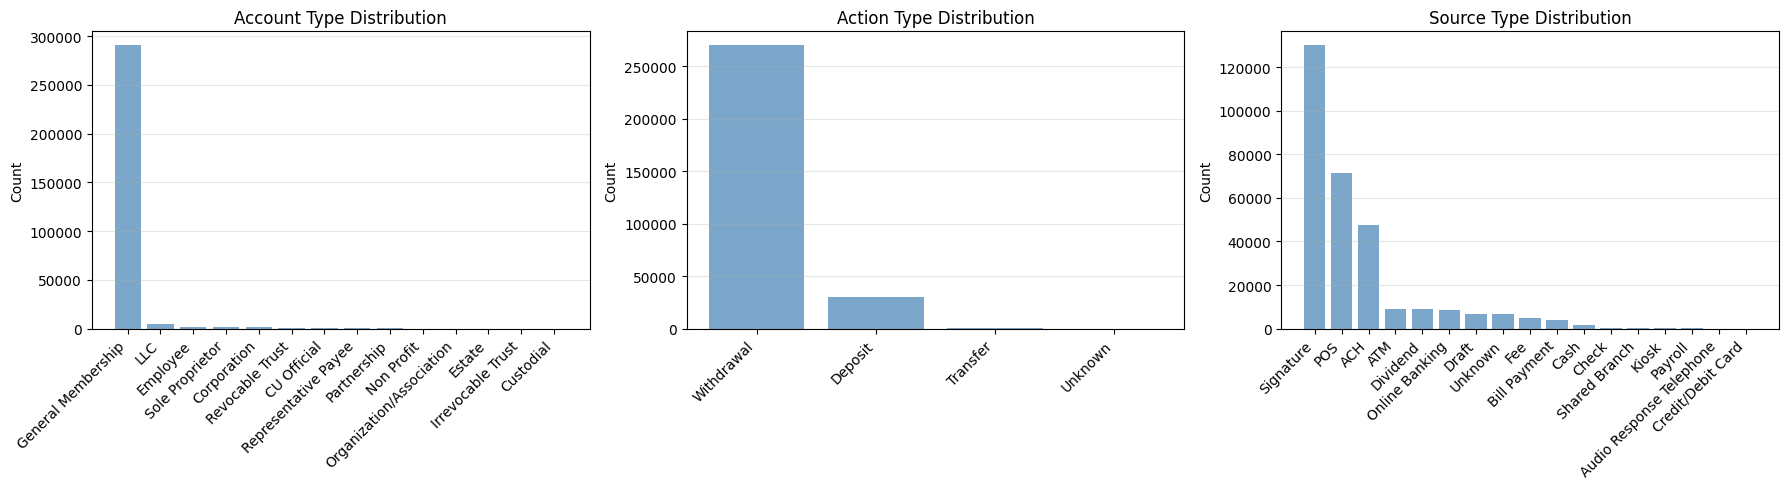

In [20]:
# ============================================
# Cell 3: Categorical Features Analysis
# ============================================

# Select categorical 03_feature_engineering for clustering
categorical_features = ['Account Type', 'Action Type', 'Source Type']

print("CATEGORICAL FEATURES ANALYSIS")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(categorical_features):
    # Handle missing values
    df[col] = df[col].fillna('Unknown')

    # Get value counts
    value_counts = df[col].value_counts()

    print(f"\n{col}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Distribution:")
    for val, count in value_counts.items():
        print(f"    {val}: {count:,} ({count/len(df)*100:.2f}%)")

    # Plot
    axes[idx].bar(range(len(value_counts)), value_counts.values, color='steelblue', alpha=0.7)
    axes[idx].set_xticks(range(len(value_counts)))
    axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

FEATURE ENCODING

Account Type: Encoded 14 categories
  Mapping: {'CU Official': np.int64(0), 'Corporation': np.int64(1), 'Custodial': np.int64(2), 'Employee': np.int64(3), 'Estate': np.int64(4), 'General Membership': np.int64(5), 'Irrevocable Trust': np.int64(6), 'LLC': np.int64(7), 'Non Profit': np.int64(8), 'Organization/Association': np.int64(9), 'Partnership': np.int64(10), 'Representative Payee': np.int64(11), 'Revocable Trust': np.int64(12), 'Sole Proprietor': np.int64(13)}

Action Type: Encoded 4 categories
  Mapping: {'Deposit': np.int64(0), 'Transfer': np.int64(1), 'Unknown': np.int64(2), 'Withdrawal': np.int64(3)}

Source Type: Encoded 17 categories
  Mapping: {'ACH': np.int64(0), 'ATM': np.int64(1), 'Audio Response Telephone': np.int64(2), 'Bill Payment': np.int64(3), 'Cash': np.int64(4), 'Check': np.int64(5), 'Credit/Debit Card': np.int64(6), 'Dividend': np.int64(7), 'Draft': np.int64(8), 'Fee': np.int64(9), 'Kiosk': np.int64(10), 'Online Banking': np.int64(11), 'POS': np.

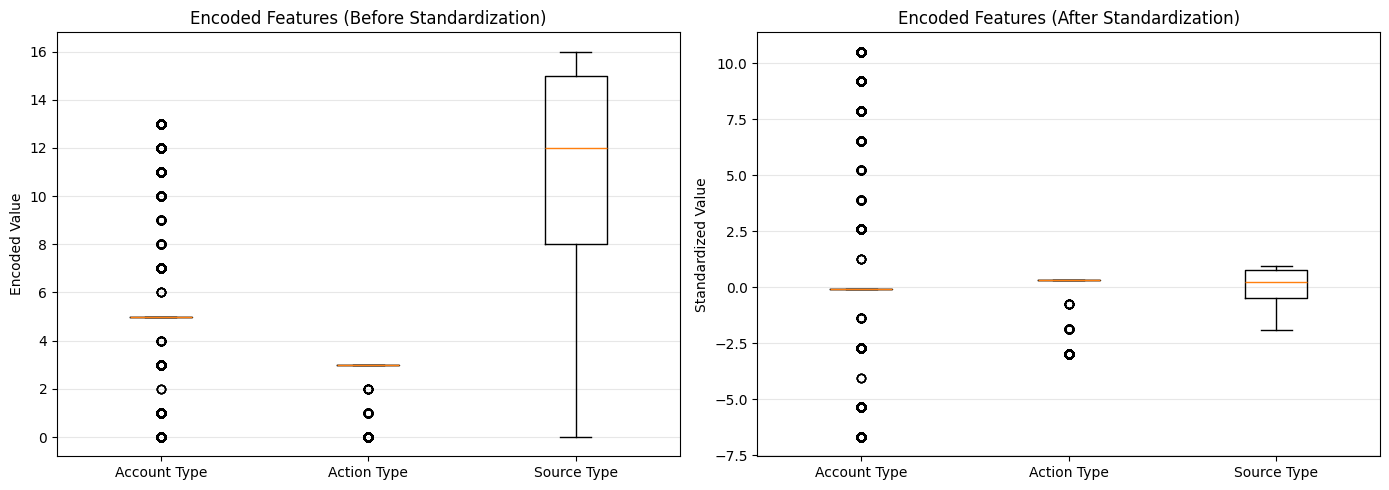

In [29]:
# ============================================
# Cell 4: Feature Encoding
# ============================================

print("FEATURE ENCODING")
print("="*60)

# Label encode categorical 03_feature_engineering
label_encoders = {}
encoded_features = []

for col in categorical_features:
    le = LabelEncoder()
    encoded_col = le.fit_transform(df[col])
    encoded_features.append(encoded_col)
    label_encoders[col] = le
    print(f"\n{col}: Encoded {len(le.classes_)} categories")
    print(f"  Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Combine encoded 03_feature_engineering
X_encoded = np.column_stack(encoded_features)
print(f"\nEncoded feature matrix shape: {X_encoded.shape}")

# Standardize 03_feature_engineering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
print(f"Standardized feature matrix shape: {X_scaled.shape}")

# Visualize encoded 03_feature_engineering
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before standardization
axes[0].boxplot([X_encoded[:, i] for i in range(X_encoded.shape[1])], tick_labels=categorical_features)
axes[0].set_ylabel('Encoded Value')
axes[0].set_title('Encoded Features (Before Standardization)')
axes[0].grid(True, alpha=0.3, axis='y')

# After standardization
axes[1].boxplot([X_scaled[:, i] for i in range(X_scaled.shape[1])], tick_labels=categorical_features)
axes[1].set_ylabel('Standardized Value')
axes[1].set_title('Encoded Features (After Standardization)')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

DETERMINING OPTIMAL NUMBER OF CLUSTERS
Testing different K values...

K             Inertia   Silhouette   Davies-Bouldin
--------------------------------------------------
2          584,143.56       0.7012           0.5803
3          353,517.92       0.7796           0.4209
4          150,021.05       0.8050           0.3296
5          109,553.16       0.8174           0.5211
6           88,979.32       0.8274           0.5161
7           67,241.12       0.8579           0.4192
8           47,168.96       0.8715           0.5075
9           41,600.02       0.8813           0.4911
10          34,634.94       0.8833           0.5025

OPTIMAL K RECOMMENDATIONS
Best K (Silhouette Score):    10 (score: 0.8833)
Best K (Davies-Bouldin):      4 (score: 0.3296)
Best K (Elbow Method):        4


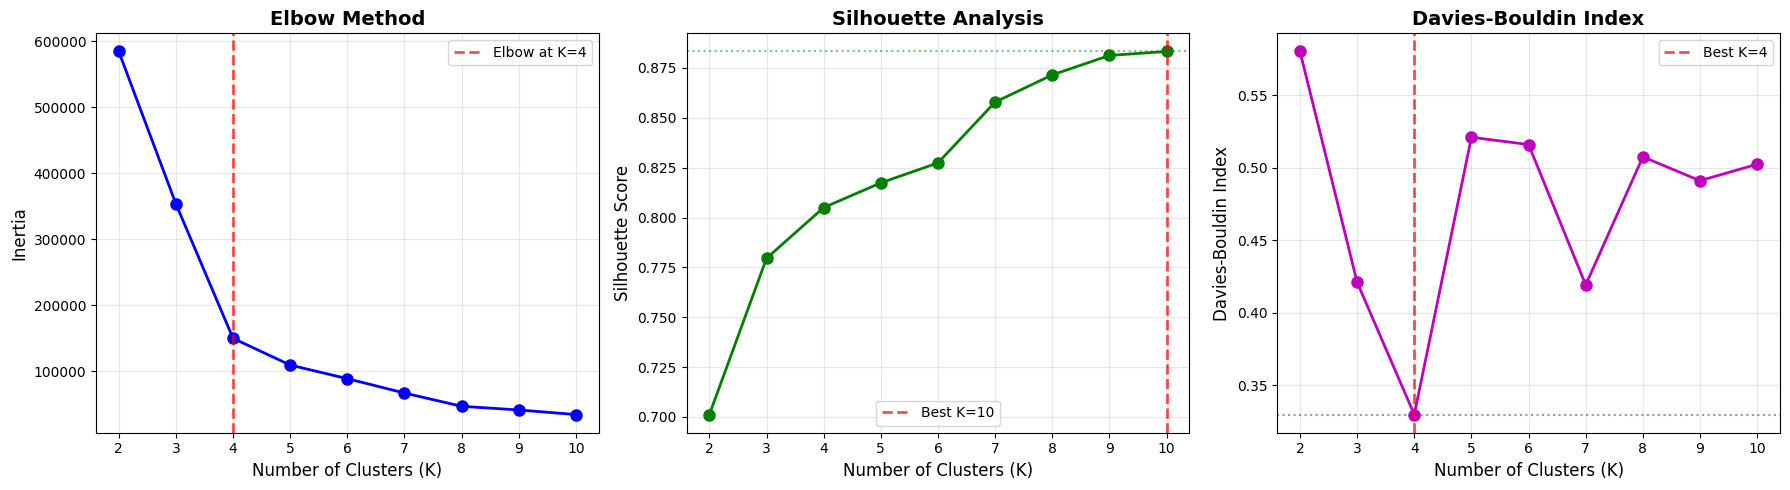

In [30]:
# ============================================
# Cell 5: Determine Optimal Number of Clusters
# ============================================
print("DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("=" * 60)

# Test different k values
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("Testing different K values...\n")
print(f"{'K':<5} {'Inertia':>15} {'Silhouette':>12} {'Davies-Bouldin':>16}")
print("-" * 50)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)

    inertia = kmeans.inertia_
    sil_score = silhouette_score(X_scaled, labels)
    db_score = davies_bouldin_score(X_scaled, labels)

    inertias.append(inertia)
    silhouette_scores.append(sil_score)
    davies_bouldin_scores.append(db_score)

    print(f"{k:<5} {inertia:>15,.2f} {sil_score:>12.4f} {db_score:>16.4f}")

# Find best k using multiple metrics
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
best_k_davies = k_range[np.argmin(davies_bouldin_scores)]

print("\n" + "=" * 60)
print("OPTIMAL K RECOMMENDATIONS")
print("=" * 60)
print(f"Best K (Silhouette Score):    {best_k_silhouette} (score: {max(silhouette_scores):.4f})")
print(f"Best K (Davies-Bouldin):      {best_k_davies} (score: {min(davies_bouldin_scores):.4f})")

# Calculate elbow point using the "knee" method
from kneed import KneeLocator

try:
    kn = KneeLocator(k_range, inertias, curve='convex', direction='decreasing')
    elbow_k = kn.elbow
    print(f"Best K (Elbow Method):        {elbow_k}")
except:
    elbow_k = None
    print(f"Best K (Elbow Method):        Unable to detect clear elbow")

print("=" * 60)

# Plot evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Elbow curve
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
if elbow_k:
    axes[0].axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7,
                    label=f'Elbow at K={elbow_k}', linewidth=2)
    axes[0].legend()

# 2. Silhouette score
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=best_k_silhouette, color='red', linestyle='--', alpha=0.7,
                label=f'Best K={best_k_silhouette}', linewidth=2)
axes[1].axhline(y=max(silhouette_scores), color='green', linestyle=':', alpha=0.5)
axes[1].legend()

# 3. Davies-Bouldin Index
axes[2].plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[2].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[2].set_title('Davies-Bouldin Index', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].axvline(x=best_k_davies, color='red', linestyle='--', alpha=0.7,
                label=f'Best K={best_k_davies}', linewidth=2)
axes[2].axhline(y=min(davies_bouldin_scores), color='purple', linestyle=':', alpha=0.5)
axes[2].legend()

plt.tight_layout()
plt.show()

In [31]:
# You can adjust this based on the evaluation above
optimal_k = 4  # Change this based on last analysis

print(f"PERFORMING CLUSTERING WITH K={optimal_k}")
print("="*60)

# Fit final clustering model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=500)
cluster_labels = final_kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['Transaction_Pattern_Cluster'] = cluster_labels

print(f"Clustering completed!")
print(f"Generated {optimal_k} transaction behavior pattern categories")
print(f"\nCluster distribution:")
cluster_counts = df['Transaction_Pattern_Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"  Cluster {cluster_id}: {count:,} transactions ({count/len(df)*100:.2f}%)")



PERFORMING CLUSTERING WITH K=4
Clustering completed!
Generated 4 transaction behavior pattern categories

Cluster distribution:
  Cluster 0: 216,802 transactions (72.27%)
  Cluster 1: 51,158 transactions (17.05%)
  Cluster 2: 29,775 transactions (9.93%)
  Cluster 3: 2,265 transactions (0.76%)


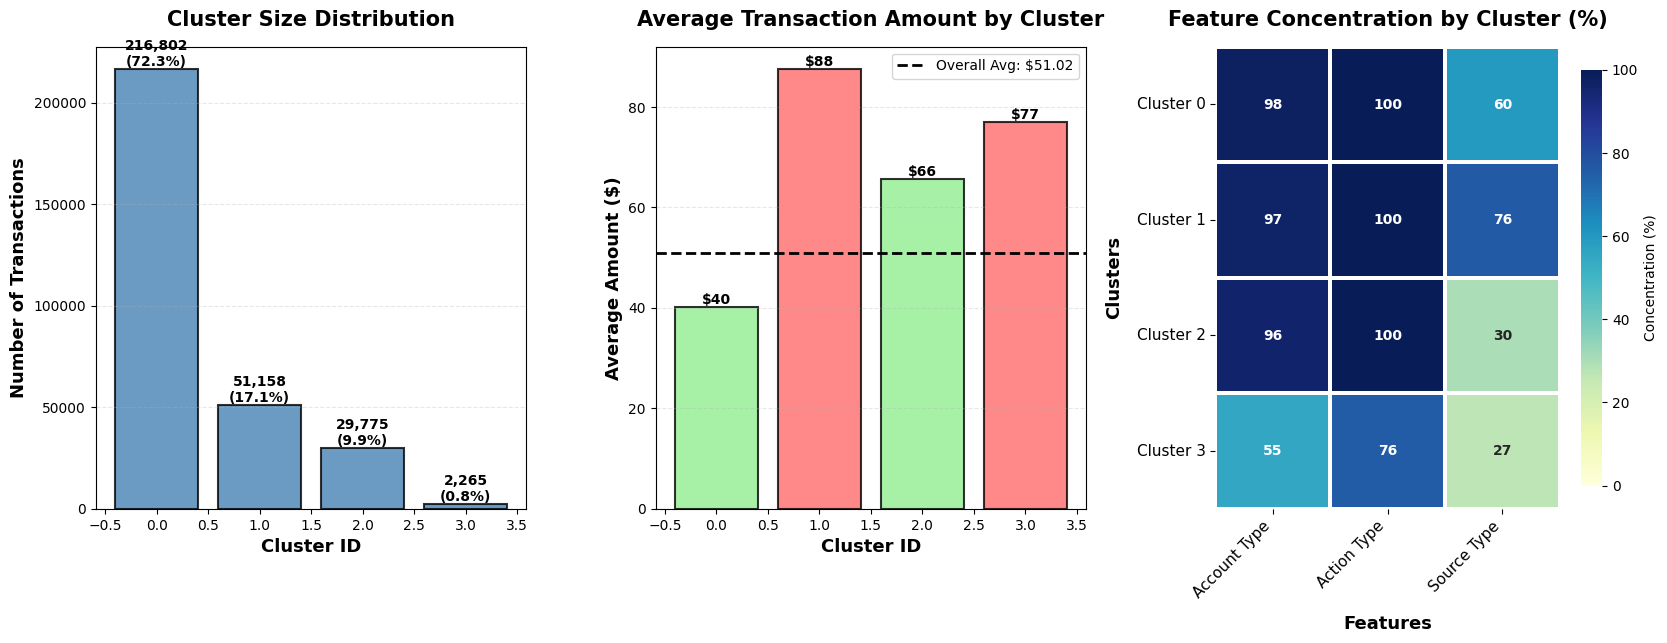


CLUSTER ANALYSIS SUMMARY


,Cluster,Size,Percentage,Unique_Users,Account Type_Top,Action Type_Top,Source Type_Top,Mean_Amount,Median_Amount,Std_Amount,Fraud_Rate,Risk_Level
0,0,216802,72.3%,1225,General Membership (97.9%),Withdrawal (100.0%),Signature (59.7%),$40.10,$22.55,$48.21,0.01%,LOW
1,1,51158,17.1%,1036,General Membership (96.7%),Withdrawal (100.0%),ACH (76.2%),$87.62,$65.00,$71.41,0.00%,LOW
2,2,29775,9.9%,1570,General Membership (95.8%),Deposit (99.8%),Dividend (30.0%),$65.66,$35.00,$82.78,0.44%,LOW
3,3,2265,0.8%,25,Sole Proprietor (55.3%),Withdrawal (75.6%),ACH (26.8%),$76.94,$50.00,$73.29,0.04%,LOW


✅ Dimensionality Reduction: 3 features → 1 cluster feature
✅ Total Transactions: 300,000
✅ Optimal K: 4 clusters


In [32]:
# ============================================
# Cell 7: Cluster Analysis & Profiling
# ============================================

# --------------------------------------------
# Statistical Analysis
# --------------------------------------------

cluster_analysis = []

for cluster_id in range(optimal_k):
    cluster_data = df[df['Transaction_Pattern_Cluster'] == cluster_id]

    analysis = {
        'Cluster': cluster_id,
        'Size': len(cluster_data),
        'Percentage': f"{len(cluster_data) / len(df) * 100:.1f}%",
        'Unique_Users': cluster_data['Member ID'].nunique()
    }

    # Categorical 03_feature_engineering
    for col in categorical_features:
        if len(cluster_data) > 0 and col in cluster_data.columns:
            mode_values = cluster_data[col].mode()
            if len(mode_values) > 0:
                top_value = mode_values[0]
                top_percentage = (cluster_data[col] == top_value).sum() / len(cluster_data) * 100
                analysis[f'{col}_Top'] = f"{top_value} ({top_percentage:.1f}%)"

    # Numerical 03_feature_engineering
    if 'Amount' in df.columns:
        analysis['Mean_Amount'] = f"${cluster_data['Amount'].mean():.2f}"
        analysis['Median_Amount'] = f"${cluster_data['Amount'].median():.2f}"
        analysis['Std_Amount'] = f"${cluster_data['Amount'].std():.2f}"

    if 'Is_Fraud' in df.columns:
        fraud_rate = cluster_data['Is_Fraud'].mean() * 100
        analysis['Fraud_Rate'] = f"{fraud_rate:.2f}%"
        analysis['Risk_Level'] = 'HIGH' if fraud_rate > 50 else 'MEDIUM' if fraud_rate > 20 else 'LOW'

    cluster_analysis.append(analysis)

analysis_df = pd.DataFrame(cluster_analysis)

# --------------------------------------------
# Visualization
# --------------------------------------------

fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(1, 3, hspace=0.3, wspace=0.3)

# Chart 1: Cluster Size Distribution
ax1 = fig.add_subplot(gs[0, 0])
cluster_counts = df['Transaction_Pattern_Cluster'].value_counts().sort_index()
bars = ax1.bar(cluster_counts.index, cluster_counts.values,
               color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Cluster ID', fontsize=13, fontweight='bold')
ax1.set_ylabel('Number of Transactions', fontsize=13, fontweight='bold')
ax1.set_title('Cluster Size Distribution', fontsize=15, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')

for idx, v in zip(cluster_counts.index, cluster_counts.values):
    ax1.text(idx, v, f'{v:,}\n({v / len(df) * 100:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Chart 2: Average Amount by Cluster
ax2 = fig.add_subplot(gs[0, 1])
if 'Amount' in df.columns:
    avg_amounts = df.groupby('Transaction_Pattern_Cluster')['Amount'].mean().sort_index()
    colors_amount = ['#90EE90' if x < avg_amounts.mean() else '#FF6B6B' for x in avg_amounts.values]

    bars = ax2.bar(avg_amounts.index, avg_amounts.values,
                   color=colors_amount, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Cluster ID', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Average Amount ($)', fontsize=13, fontweight='bold')
    ax2.set_title('Average Transaction Amount by Cluster', fontsize=15, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

    overall_avg = df['Amount'].mean()
    ax2.axhline(y=overall_avg, color='black', linestyle='--', linewidth=2,
                label=f'Overall Avg: ${overall_avg:.2f}')
    ax2.legend(fontsize=10, loc='upper right')

    for idx, v in zip(avg_amounts.index, avg_amounts.values):
        ax2.text(idx, v, f'${v:.0f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Chart 3: Feature Concentration Heatmap
ax3 = fig.add_subplot(gs[0, 2])

feature_cluster_matrix = np.zeros((optimal_k, len(categorical_features)))

for i, cluster_id in enumerate(range(optimal_k)):
    cluster_data = df[df['Transaction_Pattern_Cluster'] == cluster_id]
    for j, col in enumerate(categorical_features):
        if len(cluster_data) > 0 and col in cluster_data.columns:
            mode_values = cluster_data[col].mode()
            if len(mode_values) > 0:
                mode_value = mode_values[0]
                mode_percentage = (cluster_data[col] == mode_value).sum() / len(cluster_data) * 100
                feature_cluster_matrix[i, j] = mode_percentage

heatmap_df = pd.DataFrame(
    feature_cluster_matrix,
    index=[f'Cluster {i}' for i in range(optimal_k)],
    columns=categorical_features
)

sns.heatmap(heatmap_df,
            annot=True,
            fmt='.0f',
            cmap='YlGnBu',
            vmin=0,
            vmax=100,
            cbar_kws={'label': 'Concentration (%)', 'shrink': 0.9},
            linewidths=1.5,
            linecolor='white',
            ax=ax3,
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})

ax3.set_xlabel('Features', fontsize=13, fontweight='bold', labelpad=10)
ax3.set_ylabel('Clusters', fontsize=13, fontweight='bold', labelpad=10)
ax3.set_title('Feature Concentration by Cluster (%)', fontsize=15, fontweight='bold', pad=15)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right', fontsize=11)
ax3.set_yticklabels(ax3.get_yticklabels(), rotation=0, fontsize=11)

plt.show()

# --------------------------------------------
# Display Summary Table
# --------------------------------------------

print("\n" + "=" * 100)
print("CLUSTER ANALYSIS SUMMARY")
print("=" * 100)
display(analysis_df)
print("=" * 100)
print(f"✅ Dimensionality Reduction: {len(categorical_features)} 03_feature_engineering → 1 cluster feature")
print(f"✅ Total Transactions: {len(df):,}")
print(f"✅ Optimal K: {optimal_k} clusters")
print("=" * 100)